In [1]:
import torch


import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')


In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import importlib

import modular.initial_guesser as IG
import modular.forward_model as FM
import modular.optimize_volume_basis as OV
import modular.rotations as ROT

importlib.reload(FM)
importlib.reload(OV)
importlib.reload(IG)
importlib.reload(ROT)

<module 'modular.rotations' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\TomoNnRot\\tests\\../code\\modular\\rotations.py'>

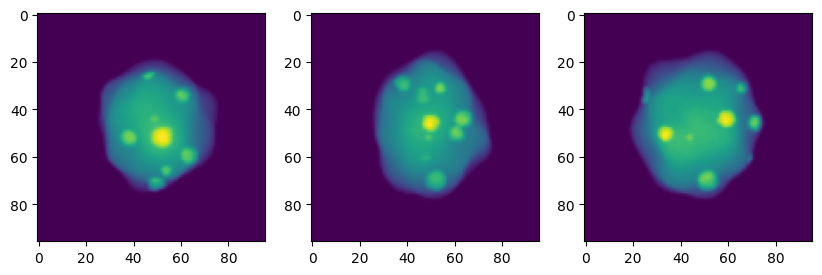

In [4]:
### Set the device ###
DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    idx = 35
    test_object = np.load('../data/potato96_1000.npz', allow_pickle=True)["test_objects"][idx]
except:
    #Create a random object, a cube with a smaller cube inside
    test_object = np.zeros((96, 96, 96))
    test_object[16:80, 16:80, 16:80] = 1
    test_object[32:64, 32:64, 32:64] = 2
    test_object[40:56, 40:56, 40:56] = 3


# Show a 3x1 plot of the object - a projection of the object in each direction
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(test_object.sum(0))
ax[1].imshow(test_object.sum(1))
ax[2].imshow(test_object.sum(2))
plt.show()


In [5]:
test_object = torch.tensor(test_object, dtype=torch.float32).to(DEV)

In [6]:
### Create a rotation model ###
forward_model = FM.ForwardModelSimple(test_object.shape[1])

In [51]:
samples = 400
Q_accum = ROT.generate_sinusoidal_quaternion(omega=2*np.pi, phi=np.pi/12, psi=np.pi/12, duration=2, samples=samples)

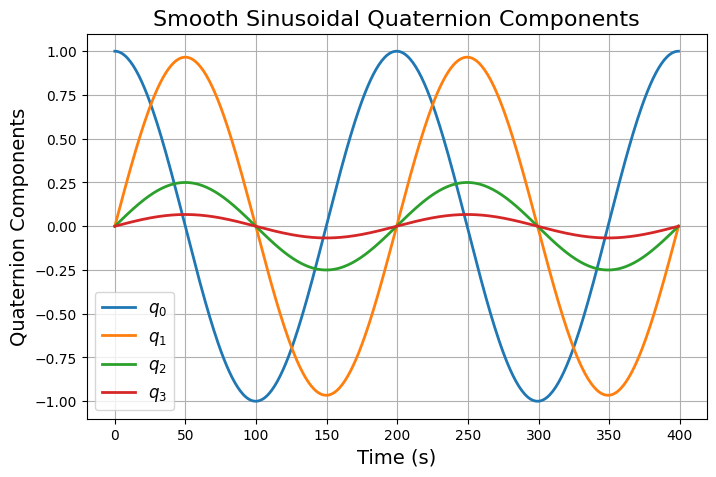

In [52]:
q0, q1, q2, q3 = Q_accum.T

# Plot the quaternion components over time
plt.figure(figsize=(8, 5))
plt.plot(q0, label=r'$q_0$', linewidth=2)
plt.plot(q1, label=r'$q_1$', linewidth=2)
plt.plot(q2, label=r'$q_2$', linewidth=2)
plt.plot(q3, label=r'$q_3$', linewidth=2)

plt.title("Smooth Sinusoidal Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Quaternion Components", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Q_accum = np.array([q0, q2, q1, q3]).T

In [53]:
Q_accum = torch.tensor(Q_accum, dtype=torch.float32).to(DEV)

In [54]:
#Get the projections
projections = forward_model(test_object, Q_accum)

In [55]:
projections.shape

torch.Size([400, 96, 96])

In [56]:
diff_projs = (projections[1:] - projections[:-1])

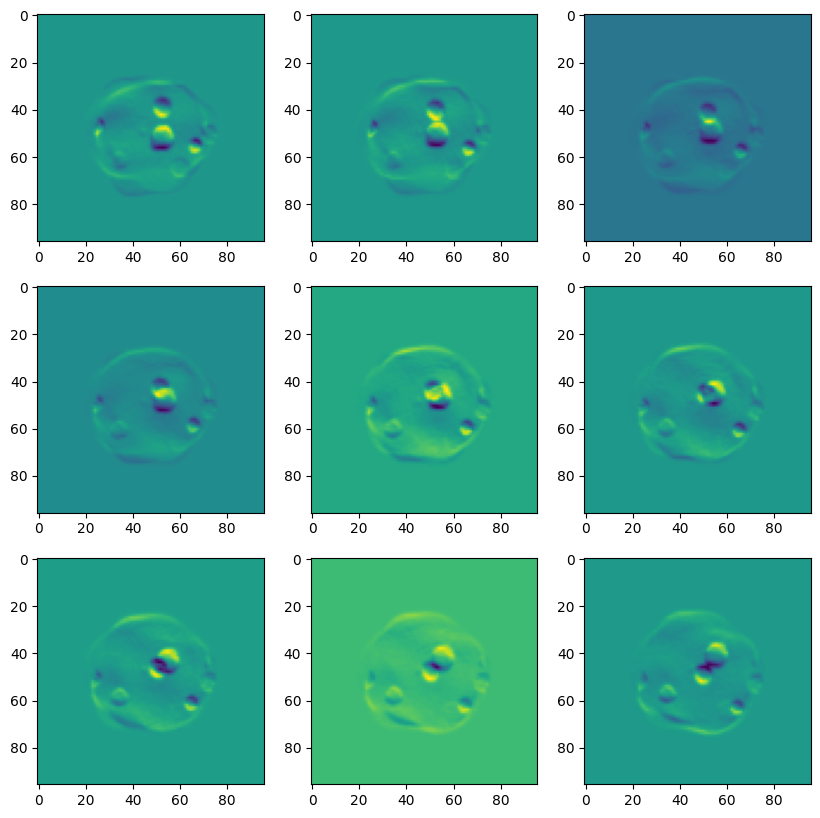

In [57]:
# Visualise 3x3 grid of projections
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(diff_projs[i*3+j].cpu().numpy())
plt.show()

In [58]:
#variance in x and y
var_x = torch.std(diff_projs, dim=(0, 1)).sum()
var_y = torch.std(diff_projs, dim=(0, 2)).sum()

In [59]:
print(f"Variance in x: {var_x}, variance in y: {var_y}")

Variance in x: 70.5054931640625, variance in y: 76.117919921875


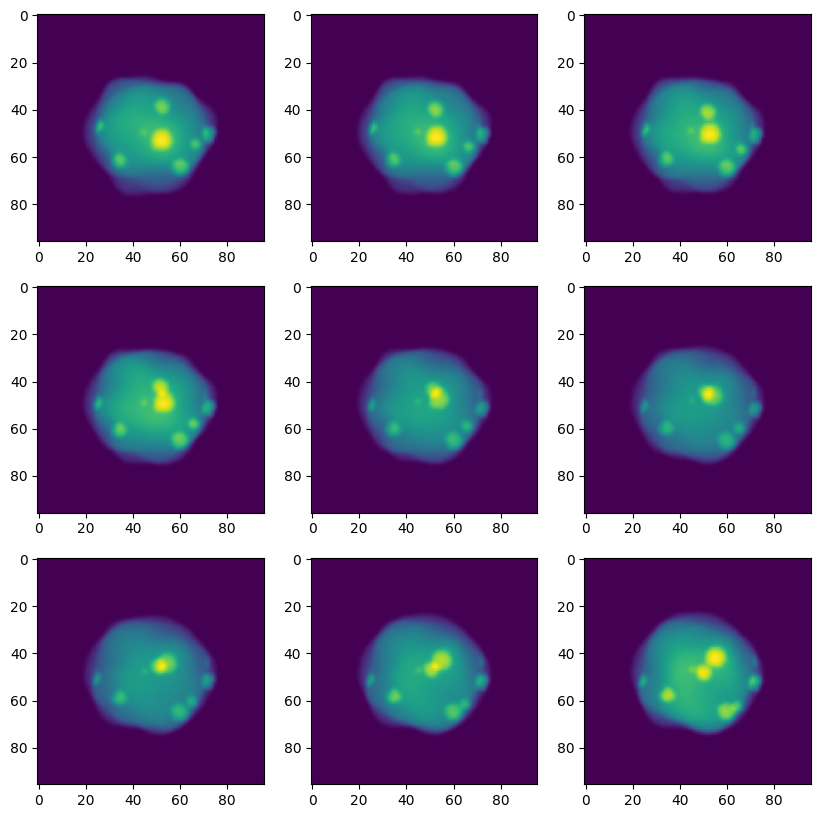

In [60]:
# Visualise 3x3 grid of projections
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(projections[i*3+j].cpu().numpy())
plt.show()

In [13]:
ig = IG.InitialGuesser(frames=projections)

In [ ]:
ig.pipeline()

Training VAE...
Epoch 1/1000, Loss: 34.72723913192749, KL Loss: 0.00905265661126009, Recon Loss: 34.718186378479004
Epoch 11/1000, Loss: 1.4226512014865875, KL Loss: 0.048403584165498614, Recon Loss: 1.3742476105690002
Epoch 21/1000, Loss: 1.37160162627697, KL Loss: 0.047826224472373724, Recon Loss: 1.3237754255533218
Epoch 31/1000, Loss: 1.2980690002441406, KL Loss: 0.04716541606467217, Recon Loss: 1.2509035766124725
Epoch 41/1000, Loss: 1.0663809478282928, KL Loss: 0.04809223965276033, Recon Loss: 1.0182887315750122
Epoch 51/1000, Loss: 1.0075993537902832, KL Loss: 0.046235578367486596, Recon Loss: 0.9613637626171112
Epoch 61/1000, Loss: 0.955449104309082, KL Loss: 0.04564579261932522, Recon Loss: 0.9098033159971237
Epoch 71/1000, Loss: 0.8688157647848129, KL Loss: 0.04413813049905002, Recon Loss: 0.8246776461601257
Epoch 81/1000, Loss: 0.8001727610826492, KL Loss: 0.04452251270413399, Recon Loss: 0.7556502372026443
Epoch 91/1000, Loss: 0.7608861699700356, KL Loss: 0.0431868711020797

c:\Users\Fredrik\Documents\GitHub\TomoNnRot\tests\../code\modular\initial_guesser.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.angle_rotations[:, 0] = torch.tensor(self.angle)


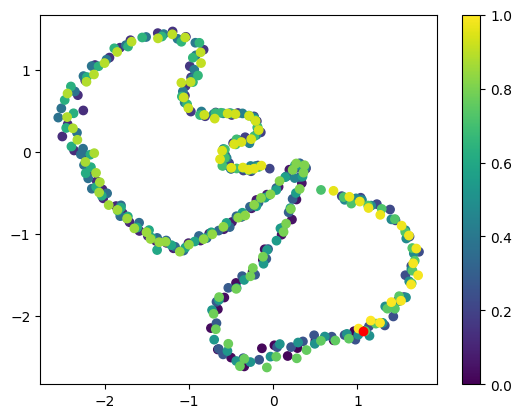

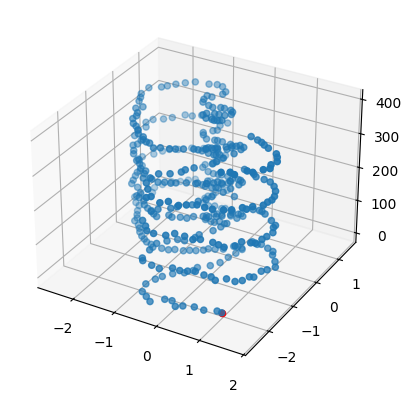

In [ ]:
#Plot z
z = ig.z.detach().cpu().numpy()
plt.scatter(z[:, 0], z[:, 1], c=np.arange(z.shape[0]))
#start_point
plt.scatter(z[0, 0], z[0, 1], c='r')
plt.colorbar()
plt.show()

#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z[:, 0], z[:, 1], np.arange(z.shape[0]))
ax.scatter(z[0, 0], z[0, 1], c='r')
plt.show()

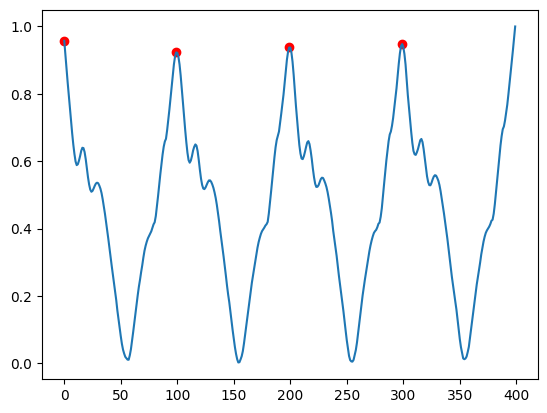

In [16]:
plt.figure()
plt.plot(ig.res)
#Add dots where the peaks from ig.peaks
plt.scatter(ig.peaks, ig.res[ig.peaks], c='r')

Text(0.5, 1.0, 'Initial Guess vs True Quaternion Components')

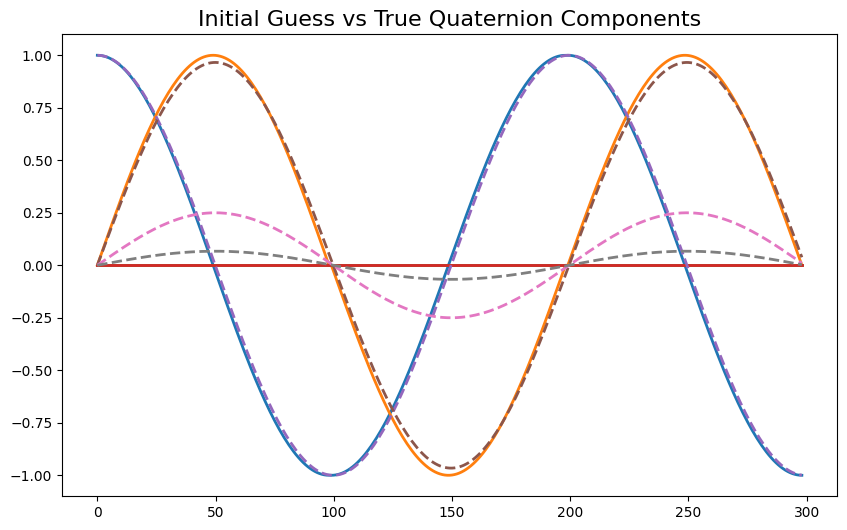

In [17]:
# Plot the quaternions
q1 = ig.quaternions.detach().cpu().numpy()
q2 = Q_accum[:len(ig.quaternions)].detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(q1[:, 0], label=r'$q_0$', linewidth=2)
plt.plot(q1[:, 1], label=r'$q_1$', linewidth=2)
plt.plot(q1[:, 2], label=r'$q_2$', linewidth=2)
plt.plot(q1[:, 3], label=r'$q_3$', linewidth=2)
plt.plot(q2[:, 0], '--', label=r'$q_0$', linewidth=2)
plt.plot(q2[:, 1], '--', label=r'$q_1$', linewidth=2)
plt.plot(q2[:, 2], '--', label=r'$q_2$', linewidth=2)
plt.plot(q2[:, 3], '--', label=r'$q_3$', linewidth=2)

plt.title("Initial Guess vs True Quaternion Components", fontsize=16)



In [18]:
import importlib
importlib.reload(OV)

<module 'modular.optimize_volume_basis' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\TomoNnRot\\tests\\../code\\modular\\optimize_volume_basis.py'>

In [19]:
ov = OV.OptimizeVolume(
    forward_model=forward_model,
    initial_guesser=ig, 
    quaternions_init=ig.quaternions, 
    projections=ig.frames,
    initial_volume='zeros',
    num_basis=32
    )

In [20]:
initial_q = ov.get_quaternions_np()

In [21]:
vol = ov.get_volume_np()

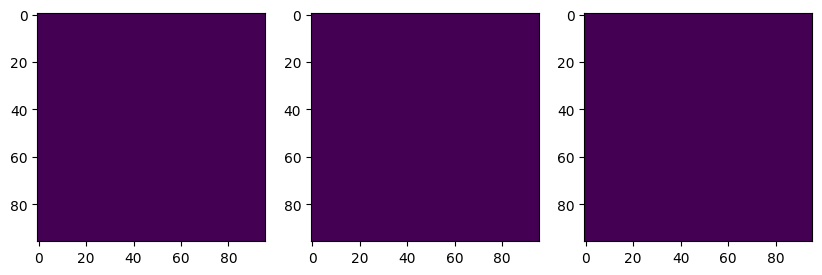

In [22]:
# Show a 3x1 plot of the object - a projection of the object in each direction
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(vol.sum(0))
ax[1].imshow(vol.sum(1))
ax[2].imshow(vol.sum(2))
plt.show()


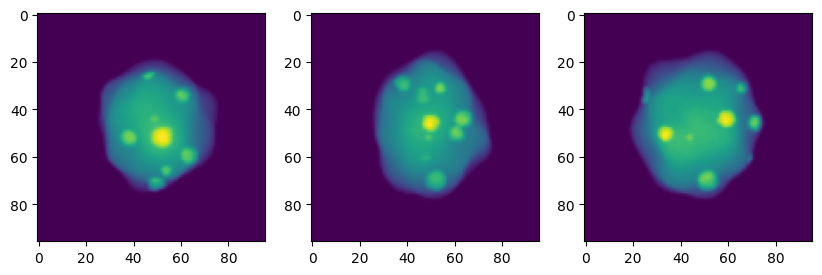

In [23]:
# Show a 3x1 plot of the object - a projection of the object in each direction
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(test_object.cpu().numpy().sum(0))
ax[1].imshow(test_object.cpu().numpy().sum(1))
ax[2].imshow(test_object.cpu().numpy().sum(2))
plt.show()

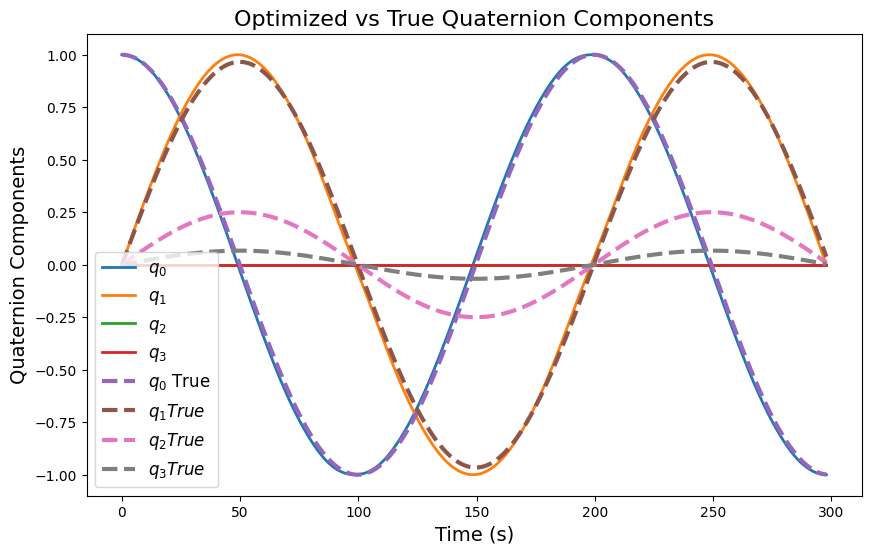

In [24]:
q3_true = Q_accum[:len(initial_q)].detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(initial_q[:, 0], '-', label=r'$q_0$', linewidth=2)
plt.plot(initial_q[:, 1], '-', label=r'$q_1$', linewidth=2)
plt.plot(initial_q[:, 2], '-', label=r'$q_2$', linewidth=2)
plt.plot(initial_q[:, 3], '-', label=r'$q_3$', linewidth=2)
plt.plot(q3_true[:, 0], '--', label=r'$q_0$ True', linewidth=3)
plt.plot(q3_true[:, 1], '--', label=r'$q_1 True$', linewidth=3)
plt.plot(q3_true[:, 2], '--', label=r'$q_2 True$', linewidth=3)
plt.plot(q3_true[:, 3], '--', label=r'$q_3 True$', linewidth=3)

plt.title("Optimized vs True Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Quaternion Components", fontsize=14)
plt.legend(fontsize=12)


In [69]:
ov.fit(
    learning_rate=1e-5,
    epochs=10000,
    loss_weights=[10, 0, 50, 0, 10],
    )

Using Adam optimizer with learning rate 1e-05
Using ReduceLROnPlateau scheduler with patience 25
Number of batches: 1
Number of epochs: 10000
Batch size: 1000
Learning rate: 1e-05
Loss weights: [10, 0, 50, 0, 10]
Using Gaussian blur: False
Optimizing volume now.
Optimizing coefficients now.
Epoch 1/10000, Total loss: 0.09308, MAE loss: 0.05436, Perception loss: 0.03756, TV loss: 0.00082, Quaternion validity loss: 0.00000, q0 constraint loss: 0.00033,
Epoch 2/10000, Total loss: 0.09835, MAE loss: 0.05862, Perception loss: 0.03858, TV loss: 0.00082, Quaternion validity loss: 0.00000, q0 constraint loss: 0.00033,
Epoch 3/10000, Total loss: 0.09840, MAE loss: 0.05692, Perception loss: 0.04033, TV loss: 0.00082, Quaternion validity loss: 0.00000, q0 constraint loss: 0.00033,
Epoch 4/10000, Total loss: 0.09575, MAE loss: 0.05514, Perception loss: 0.03946, TV loss: 0.00082, Quaternion validity loss: 0.00000, q0 constraint loss: 0.00033,
Epoch 5/10000, Total loss: 0.09615, MAE loss: 0.05497, P

KeyboardInterrupt: 

In [61]:
# Plot the loss
plt.figure(figsize=(8, 5))
plt.plot(ov.loss_mae, label="Loss", linewidth=2)
plt.title("Loss over Optimization", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

NameError: name 'ov' is not defined

<Figure size 800x500 with 0 Axes>

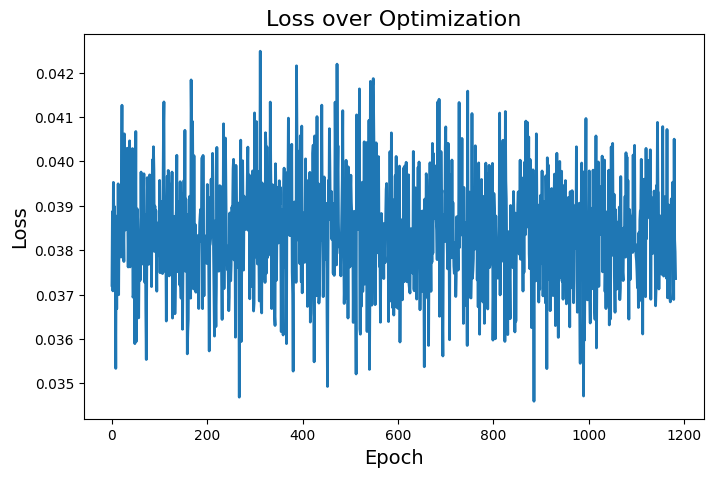

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(ov.p_loss[800:], label="Loss", linewidth=2)
plt.title("Loss over Optimization", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

In [72]:
vol = ov.get_volume_np()
projections_pred = ov.get_projections_np()
quaternions_pred = ov.get_quaternions_np()

In [73]:
#Set pixels to close to border to 0
pad = 8
vol[:, :pad, :] = 0
vol[:, -pad:, :] = 0
vol[:, :, :pad] = 0
vol[:, :, -pad:] = 0
vol[:pad, :, :] = 0
vol[-pad:, :, :] = 0

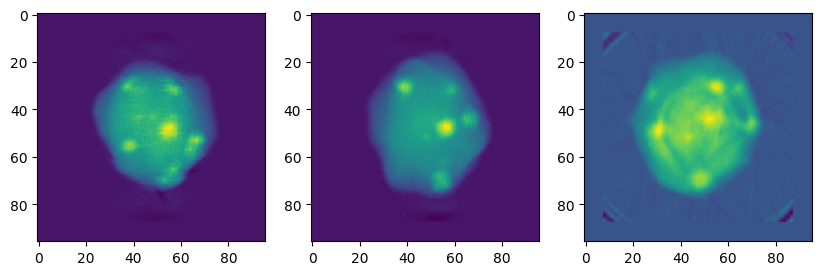

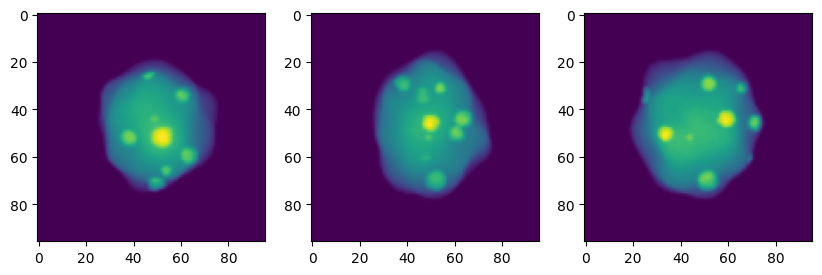

In [74]:
# Show a 3x1 plot of the object - a projection of the object in each direction
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(vol.sum(0))
ax[1].imshow(vol.sum(1))
ax[2].imshow(vol.sum(2))
plt.show()

# Show a 3x1 plot of the object - a projection of the object in each direction
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(test_object.cpu().numpy().sum(0))
ax[1].imshow(test_object.cpu().numpy().sum(1))
ax[2].imshow(test_object.cpu().numpy().sum(2))
plt.show()

In [75]:
# Set negative values to 0 in projections_pred
#projections_pred[projections_pred < 0] = 0


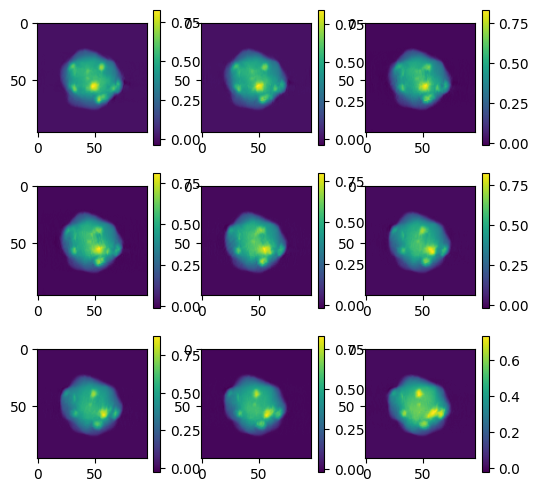

In [76]:
# Visualise 3x3 grid of projections
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        im = ax[i, j].imshow(projections_pred[i*3+j])
        fig.colorbar(im, ax=ax[i, j])
plt.show()

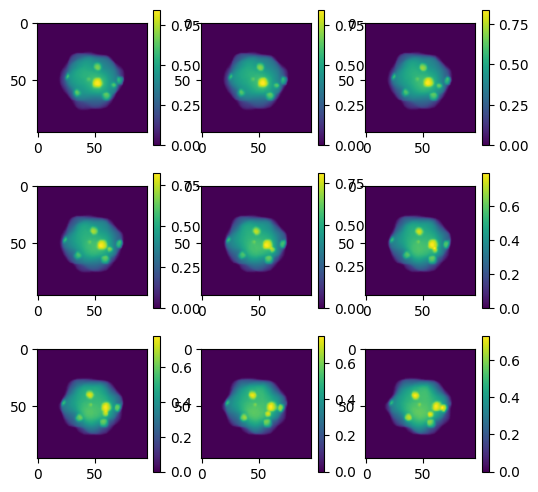

In [ ]:
# Visualise 3x3 grid of projections
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        im = ax[i, j].imshow(ig.frames.squeeze(1).cpu().numpy()[i*3+j])
        fig.colorbar(im, ax=ax[i, j])
plt.show()

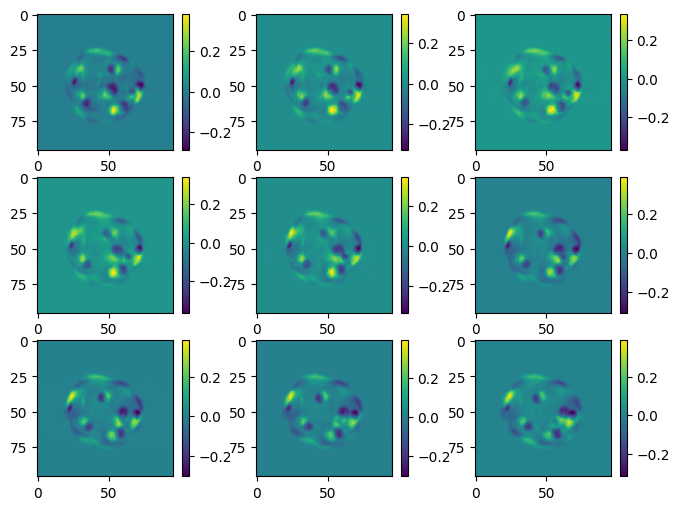

In [ ]:
# Visualise 3x3 grid of projections (difference)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for i in range(3):
    for j in range(3):
        im=ax[i, j].imshow(projections_pred[i*3+j] - ig.frames.squeeze(1).cpu().numpy()[i*3+j])
        fig.colorbar(im, ax=ax[i, j])
    
plt.show()


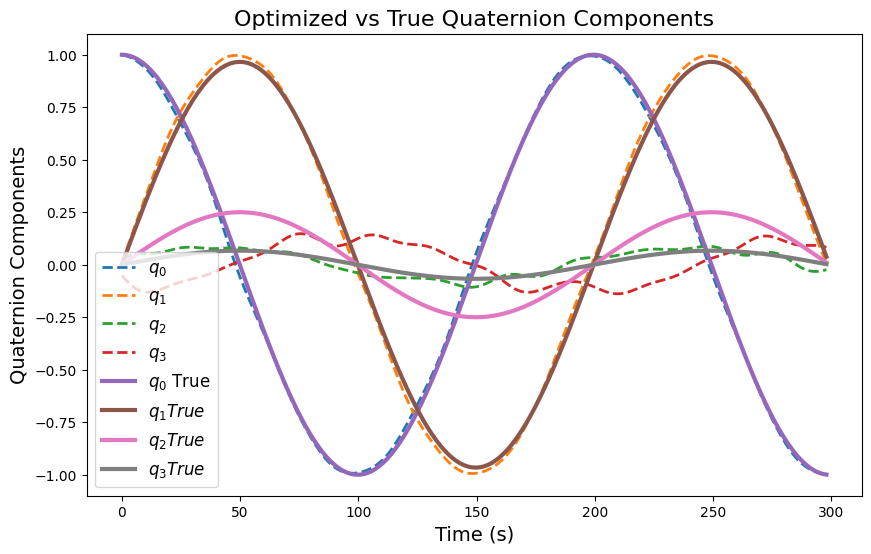

In [79]:
q2_optimized = quaternions_pred
q3_true = Q_accum[:len(q2_optimized)].detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(q2_optimized[:, 0], '--', label=r'$q_0$', linewidth=2)
plt.plot(q2_optimized[:, 1], '--', label=r'$q_1$', linewidth=2)
plt.plot(q2_optimized[:, 2], '--', label=r'$q_2$', linewidth=2)
plt.plot(q2_optimized[:, 3], '--', label=r'$q_3$', linewidth=2)
plt.plot(q3_true[:, 0], '-', label=r'$q_0$ True', linewidth=3)
plt.plot(q3_true[:, 1], '-', label=r'$q_1 True$', linewidth=3)
plt.plot(q3_true[:, 2], '-', label=r'$q_2 True$', linewidth=3)
plt.plot(q3_true[:, 3], '-', label=r'$q_3 True$', linewidth=3)

plt.title("Optimized vs True Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Quaternion Components", fontsize=14)
plt.legend(fontsize=12)

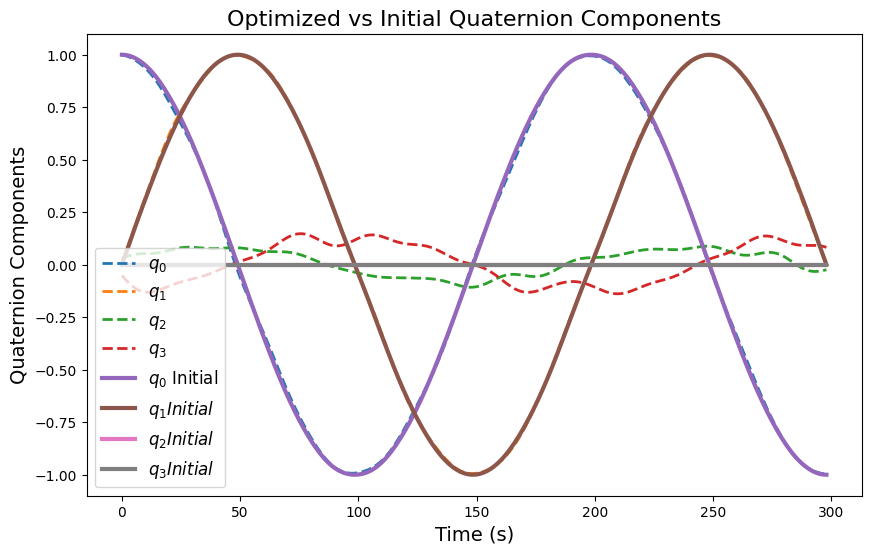

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(q2_optimized[:, 0], '--', label=r'$q_0$', linewidth=2)
plt.plot(q2_optimized[:, 1], '--', label=r'$q_1$', linewidth=2)
plt.plot(q2_optimized[:, 2], '--', label=r'$q_2$', linewidth=2)
plt.plot(q2_optimized[:, 3], '--', label=r'$q_3$', linewidth=2)
plt.plot(initial_q[:, 0], '-', label=r'$q_0$ Initial', linewidth=3)
plt.plot(initial_q[:, 1], '-', label=r'$q_1 Initial$', linewidth=3)
plt.plot(initial_q[:, 2], '-', label=r'$q_2 Initial$', linewidth=3)
plt.plot(initial_q[:, 3], '-', label=r'$q_3 Initial$', linewidth=3)

plt.title("Optimized vs Initial Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Quaternion Components", fontsize=14)
plt.legend(fontsize=12)

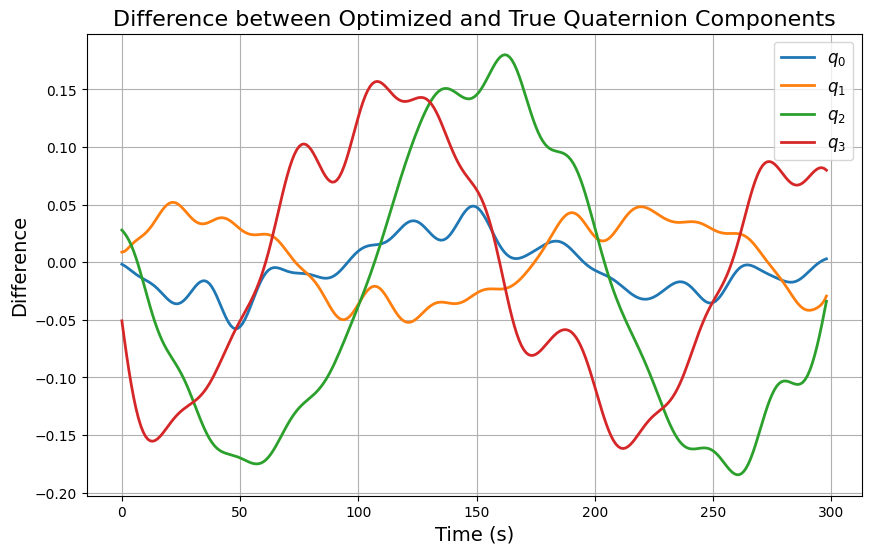

In [81]:
#Difference plot
plt.figure(figsize=(10, 6))
plt.plot(q2_optimized[:, 0] - q3_true[:, 0], '-', label=r'$q_0$', linewidth=2)
plt.plot(q2_optimized[:, 1] - q3_true[:, 1], '-', label=r'$q_1$', linewidth=2)
plt.plot(q2_optimized[:, 2] - q3_true[:, 2], '-', label=r'$q_2$', linewidth=2)
plt.plot(q2_optimized[:, 3] - q3_true[:, 3], '-', label=r'$q_3$', linewidth=2)
plt.title("Difference between Optimized and True Quaternion Components", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Difference", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)


In [82]:
frames = torch.tensor(ov.get_projections_np()).unsqueeze(1).to(DEV)

x_recon, mu, logvar = ig.model_vae(frames)
zp = ig.model_vae.reparameterize(mu, logvar).detach().cpu().numpy()

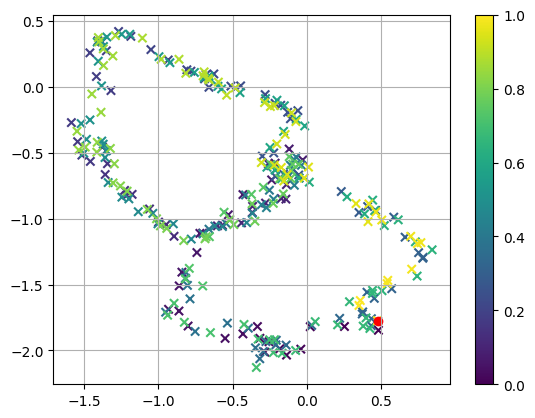

In [ ]:
plt.scatter(zp[:, 0], zp[:, 1], marker= 'x', c=np.arange(zp.shape[0]))
#start_point
plt.scatter(zp[0, 0], zp[0, 1], c='r')
plt.grid()
plt.colorbar()
plt.show()

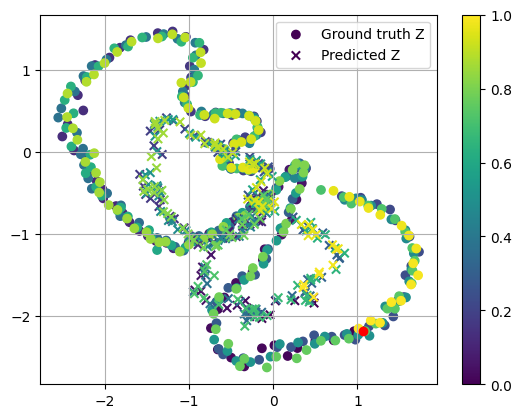

In [ ]:
z = ig.z.detach().cpu().numpy()
plt.scatter(z[:, 0], z[:, 1], c=np.arange(z.shape[0]), label='Ground truth Z')
plt.scatter(zp[:, 0], zp[:, 1] ,marker= 'x',c=np.arange(zp.shape[0]), label='Predicted Z')
#start_point
plt.scatter(z[0, 0], z[0, 1], c='r')
#Grid
plt.grid()
plt.legend()
plt.colorbar()
plt.show()

In [85]:
#Compute the distance between the points in zp and z
dist = np.linalg.norm(zp - z[:len(zp)], axis=1)

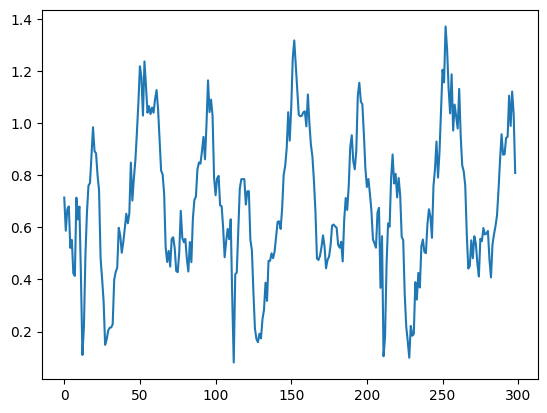

In [86]:
plt.plot(dist)